In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

2024-11-22 14:01:59.453532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732258919.555716   16677 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732258919.585979   16677 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 14:01:59.826832: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Path ke direktori dataset
train_dir = '../datasets/train_left_and_right_set'
validation_dir = '../datasets/test_left_and_right_set'

In [3]:
# Data augmentation dan preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    brightness_range=[0.8, 1.2],
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1202 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [16]:
# Load MobileNetV3 model
base_model = MobileNetV3Large(weights='imagenet', include_top=False)
x = base_model.output
x = Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.01))(x)
x = MaxPooling2D(2, 2)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

/home/brimbi21/anaconda3/envs/lDetection/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [17]:
checkpoint_path = "../model_download/left_and_right/kedua/model_left_and_right.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_path,
                monitor="val_accuracy",
                verbose=1,
                save_best_only=True,
                save_weights_only=False,
                mode="max",
                save_freq="epoch",
            )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [18]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10


2024-11-22 14:50:23.462175: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3539_0', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 14:50:26.347837: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9785', 60 bytes spill stores, 64 bytes spill loads

2024-11-22 14:50:26.406682: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9785', 68 bytes spill stores, 72 bytes spill loads

2024-11-22 14:50:26.426238: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6989', 104 bytes spill stores, 104 bytes spill loads



10/37 ━━━━━━━━━━━━━━━━━━━━ 21s 808ms/step - Precision: 0.5852 - Recall: 0.6647 - accuracy: 0.5644 - loss: 15.8608

2024-11-22 14:50:43.824527: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9785', 32 bytes spill stores, 32 bytes spill loads

2024-11-22 14:50:45.695980: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9785', 32 bytes spill stores, 32 bytes spill loads



37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - Precision: 0.5401 - Recall: 0.5445 - accuracy: 0.5358 - loss: 11.7508
Epoch 1: val_accuracy improved from -inf to 0.46875, saving model to ../model_download/left_and_right/kedua/model_left_and_right.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - Precision: 0.5392 - Recall: 0.5427 - accuracy: 0.5349 - loss: 11.6432 - val_Precision: 0.4464 - val_Recall: 0.1701 - val_accuracy: 0.4688 - val_loss: 2.6193
Epoch 2/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - Precision: 0.5385 - Recall: 0.5385 - accuracy: 0.6250 - loss: 2.6096

/home/brimbi21/anaconda3/envs/lDetection/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-22 14:51:29.009970: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1593', 4 bytes spill stores, 4 bytes spill loads




Epoch 2: val_accuracy improved from 0.46875 to 0.71429, saving model to ../model_download/left_and_right/kedua/model_left_and_right.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - Precision: 0.5385 - Recall: 0.5385 - accuracy: 0.6250 - loss: 2.6096 - val_Precision: 0.5000 - val_Recall: 0.7500 - val_accuracy: 0.7143 - val_loss: 2.4852
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - Precision: 0.4732 - Recall: 0.4200 - accuracy: 0.4735 - loss: 2.0091
Epoch 3: val_accuracy did not improve from 0.71429
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 531ms/step - Precision: 0.4732 - Recall: 0.4214 - accuracy: 0.4736 - loss: 2.0005 - val_Precision: 0.5219 - val_Recall: 0.8041 - val_accuracy: 0.5208 - val_loss: 1.2521
Epoch 4/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - Precision: 0.6087 - Recall: 0.8235 - accuracy: 0.6250 - loss: 1.2422
Epoch 4: val_accuracy did not improve from 0.71429
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.6087 - Recall: 0.8235 - accuracy: 0.6250 - loss: 1.2422 - val

2024-11-22 14:52:34.983758: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - Precision: 0.4874 - Recall: 0.5907 - accuracy: 0.4899 - loss: 1.1391
Epoch 9: val_accuracy did not improve from 0.78571
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 530ms/step - Precision: 0.4878 - Recall: 0.5879 - accuracy: 0.4902 - loss: 1.1388 - val_Precision: 0.6667 - val_Recall: 0.0138 - val_accuracy: 0.5000 - val_loss: 1.0967


In [19]:
# Unfreeze beberapa layers dari base model untuk fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Re-compile model dengan learning rate lebih rendah
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - Precision: 0.5550 - Recall: 0.5490 - accuracy: 0.5199 - loss: 0.9750
Epoch 1: val_accuracy did not improve from 0.78571
37/37 ━━━━━━━━━━━━━━━━━━━━ 49s 839ms/step - Precision: 0.5538 - Recall: 0.5477 - accuracy: 0.5195 - loss: 0.9736 - val_Precision: 0.4964 - val_Recall: 0.9577 - val_accuracy: 0.5000 - val_loss: 0.8522
Epoch 2/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - Precision: 0.2778 - Recall: 0.4167 - accuracy: 0.3750 - loss: 0.8589
Epoch 2: val_accuracy did not improve from 0.78571
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - Precision: 0.2778 - Recall: 0.4167 - accuracy: 0.3750 - loss: 0.8589 - val_Precision: 0.6429 - val_Recall: 1.0000 - val_accuracy: 0.6429 - val_loss: 0.8296
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - Precision: 0.5166 - Recall: 0.2267 - accuracy: 0.5338 - loss: 0.8262
Epoch 3: val_accuracy did not improve from 0.78571
37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 581ms/step - Precision: 0.5167 - Recall: 0.2302 - 

In [20]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(validation_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 395ms/step - Precision: 0.4771 - Recall: 1.0000 - accuracy: 0.4771 - loss: 0.7574
Loss: 0.7553185224533081, Accuracy: 0.5, Precision: 0.5, Recall: 1.0


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img, img_to_array

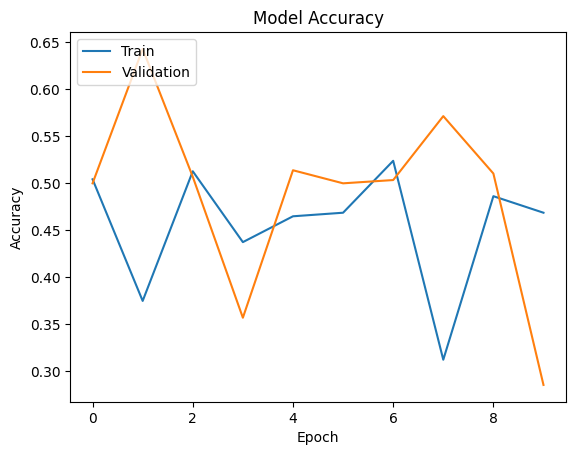

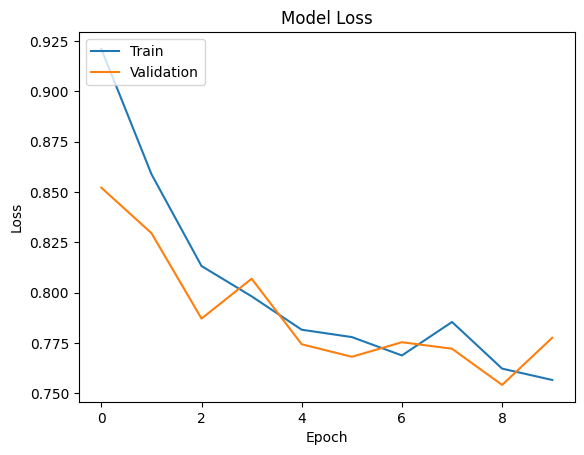

In [21]:
# Plot accuracy dan val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss dan val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Right
Confidence score: 0.5129


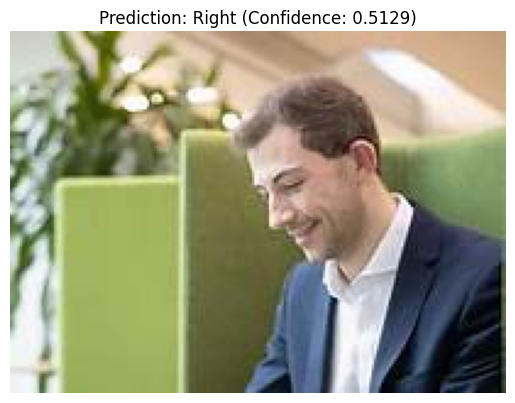

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction: Left
Confidence score: 0.5516


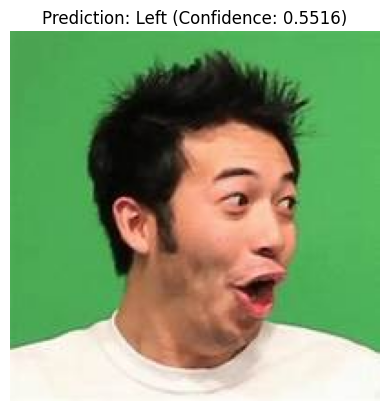

In [22]:
# Load the saved model
model = tf.keras.models.load_model('../model_download/left_and_right/kedua/model_left_and_right.keras')

# Function to preprocess an image for prediction
def preprocess_image(image_path):
  img = load_img(image_path, target_size=(224, 224))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  # img_array /= 255.  # Normalize the image if your model expects normalized input
  return img_array

# Function to predict and display results
def predict_image(image_path):
  preprocessed_image = preprocess_image(image_path)
  prediction = model.predict(preprocessed_image)

  if prediction[0][0] > 0.5:
    label = "Right"
  else:
    label = "Left"

  confidence = prediction[0][0] if label == "Right" else 1 - prediction[0][0]

  print(f"Prediction: {label}")
  print(f"Confidence score: {confidence:.4f}")
  img = mpimg.imread(image_path)
  plt.imshow(img)
  plt.title(f"Prediction: {label} (Confidence: {confidence:.4f})")
  plt.axis('off')
  plt.show()


# Example usage:
test_image_path1 = "../datasets/test/test/right.jpeg"
test_image_path2 = "../datasets/test/test/left.jpeg"


predict_image(test_image_path1)
predict_image(test_image_path2)

In [23]:
import time

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)
    return img_array

# Fungsi untuk mengukur latensi
def measure_latency(image_path, model, num_runs=100):
    preprocessed_image = preprocess_image(image_path)
    
    # Warm-up
    for _ in range(10):
        _ = model.predict(preprocessed_image)
    
    # Mengukur latensi
    start_time = time.time()
    for _ in range(num_runs):
        _ = model.predict(preprocessed_image)
    end_time = time.time()
    
    avg_latency = (end_time - start_time) / num_runs
    print(f"Average latency over {num_runs} runs: {avg_latency:.6f} seconds")

# Contoh penggunaan
test_image_path = "../datasets/test/test/right.jpeg"
measure_latency(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [24]:
# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)
    return img_array

# Mengonversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
tflite_model_path = '../model_download/left_and_right/kedua/model_left_and_right.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Mengukur latensi model TFLite
def measure_tflite_latency(image_path, tflite_model_path, num_runs=100):
    # Memuat model TFLite
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Mendapatkan ukuran input yang diharapkan
    input_shape = input_details[0]['shape'][1:3]
    
    preprocessed_image = preprocess_image(image_path, target_size=input_shape)
    
    # Warm-up
    for _ in range(10):
        interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
        interpreter.invoke()
    
    # Mengukur latensi
    start_time = time.time()
    for _ in range(num_runs):
        interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
        interpreter.invoke()
    end_time = time.time()
    
    avg_latency = (end_time - start_time) / num_runs
    print(f"Average TFLite latency over {num_runs} runs: {avg_latency:.6f} seconds")

# Contoh penggunaan
test_image_path = "../datasets/test/test/left2.jpg"
measure_tflite_latency(test_image_path, tflite_model_path)

INFO:tensorflow:Assets written to: /tmp/tmphgsscqs_/assets


INFO:tensorflow:Assets written to: /tmp/tmphgsscqs_/assets


Saved artifact at '/tmp/tmphgsscqs_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140360275336128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140360275347056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140360275349168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140360275342288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140360275344576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140360275357792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140360275355856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140360275358848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140360275355504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140360275356208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14036027535

W0000 00:00:1732262309.166470   16677 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732262309.167152   16677 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-22 14:58:29.172241: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphgsscqs_
2024-11-22 14:58:29.183573: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-22 14:58:29.183612: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmphgsscqs_
2024-11-22 14:58:29.316798: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-22 14:58:30.109840: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmphgsscqs_
2024-11-22 14:58:30.279773: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 1107854 microseconds.


Average TFLite latency over 100 runs: 0.000850 seconds


In [25]:
# Memuat model Keras
model = tf.keras.models.load_model('../model_download/left_and_right/kedua/model_left_and_right.keras')

# Mengonversi model ke TFLite dengan kuantisasi rentang dinamis
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

# Menyimpan model TFLite yang telah dikuantisasi ke file
tflite_model_quant_path = '../model_download/left_and_right/kedua/model_left_and_right_quant.tflite'
with open(tflite_model_quant_path, 'wb') as f:
    f.write(tflite_model_quant)

print("Model TFLite dengan kuantisasi rentang dinamis telah disimpan.")

INFO:tensorflow:Assets written to: /tmp/tmpczzq1_br/assets


INFO:tensorflow:Assets written to: /tmp/tmpczzq1_br/assets


Saved artifact at '/tmp/tmpczzq1_br'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140361893762448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140361893828336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140361893836960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140361893766320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140361893829392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140361893838016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140361893827104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140361893835024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140361893824640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140361893835376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14036189390

W0000 00:00:1732262338.454680   16677 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732262338.455603   16677 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-22 14:58:58.458762: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpczzq1_br
2024-11-22 14:58:58.473537: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-22 14:58:58.473575: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpczzq1_br
2024-11-22 14:58:58.612488: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-22 14:58:59.373933: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpczzq1_br
2024-11-22 14:58:59.556602: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 1098308 microseconds.


Model TFLite dengan kuantisasi rentang dinamis telah disimpan.
